In [1]:
from monteCarloSimulation_Kou import *
import pandas as pd
import gc


/Users/francis/opt/anaconda3/envs/py310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/francis/opt/anaconda3/envs/py310/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
################ Change the LTV0 here to produce option prices for other values of LTV0 ################
LTV0 = 0.3
########################################################################################################

In [2]:
params = pd.read_csv('2024-10-15_Kou_calibration_result.csv', header=0, index_col=0).T

In [3]:
params

,date,sigma,eta_p,eta_m,lambda,p,spot_price
0,2024-10-15 16:14:51.056756,0.47828097861957763,0.18444910400790435,0.17696526515878447,1.8895264088145356,0.44585671289349854,67381.0


In [4]:
r         = 0
sigma     = float(params.sigma[0])
_lambda   = float(params['lambda'][0])
S0        = float(params['spot_price'][0])
eta1      = 1/float(params['eta_p'][0])
eta2      = 1/float(params['eta_m'][0])
p         = float(params['p'][0])
q         = 1-p
T         = 365/365
M         = 365*3
dt        = T/M
N         = 5_000

LTVH = 0.9
LP   = 0.05

K  = S0*LTV0          # Strike price
H  = S0*LTV0/LTVH     # Barrier level

H, K, dt*365

/var/folders/cx/r29qtv6d47gc4c3vgvtvlgth0000gn/T/ipykernel_18301/2146170187.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma     = float(params.sigma[0])
/var/folders/cx/r29qtv6d47gc4c3vgvtvlgth0000gn/T/ipykernel_18301/2146170187.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  _lambda   = float(params['lambda'][0])
/var/folders/cx/r29qtv6d47gc4c3vgvtvlgth0000gn/T/ipykernel_18301/2146170187.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

(22460.333333333332, 20214.3, 0.3333333333333333)

In [5]:
kappa_arr = np.round(np.arange(-0.3, 0.4, 0.05), 4)
kappa_arr = np.array(kappa_arr)
kappa_arr

array([-0.3 , -0.25, -0.2 , -0.15, -0.1 , -0.05, -0.  ,  0.05,  0.1 ,
        0.15,  0.2 ,  0.25,  0.3 ,  0.35])

In [6]:
step = 3*7
endSteps_arr = np.arange(step, M+step, step)
endSteps_arr

array([  21,   42,   63,   84,  105,  126,  147,  168,  189,  210,  231,
        252,  273,  294,  315,  336,  357,  378,  399,  420,  441,  462,
        483,  504,  525,  546,  567,  588,  609,  630,  651,  672,  693,
        714,  735,  756,  777,  798,  819,  840,  861,  882,  903,  924,
        945,  966,  987, 1008, 1029, 1050, 1071, 1092, 1113])

In [7]:
res = dict()

k_folds = 5

paths_infos = []

for seed in range(k_folds):
    print(seed)
    paths_info = simulate_kou_model_paths(seed, S0, r, sigma, _lambda, p, eta1, eta2, T, M, N)
    paths_infos.append(paths_info) # times_with_jumps, base_times_mask, S, S_t_minus, S_BBmin

for kappa in kappa_arr:
    print(kappa)
    res[kappa] = {'V_train':[], 'V_test':[]}
    for i in range(k_folds):
        times_with_jumps_train = sum([paths_infos[k][0] for k in range(k_folds) if k != i], [])
        base_times_mask_train  = sum([paths_infos[k][1] for k in range(k_folds) if k != i], [])
        S_train                = sum([paths_infos[k][2] for k in range(k_folds) if k != i], [])
        S_t_minus_train        = sum([paths_infos[k][3] for k in range(k_folds) if k != i], [])
        S_BBmin_train          = sum([paths_infos[k][4] for k in range(k_folds) if k != i], [])
        
        times_with_jumps_test  = paths_infos[i][0]
        base_times_mask_test   = paths_infos[i][1]
        S_test                 = paths_infos[i][2]
        S_t_minus_test         = paths_infos[i][3]
        S_BBmin_test           = paths_infos[i][4]
        
        time_train, S_train, payoffs_train, liquidation_mask_train = compute_payoffs(times_with_jumps_train, base_times_mask_train, S_train, S_t_minus_train, S_BBmin_train, K, H, LP, r, kappa)
        time_test, S_test, payoffs_test, liquidation_mask_test = compute_payoffs(times_with_jumps_test, base_times_mask_test, S_test, S_t_minus_test, S_BBmin_test, K, H, LP, r, kappa)
        
        V_train_res = dict()
        V_test_res  = dict()
        for endStep in endSteps_arr:
            _T = endStep * dt
            _T = np.round(_T, 4)
            endStep_mask = (time_train <= _T)[0]
            print(kappa, i, endStep, _T)

            _time_train, _S_train, _payoffs_train, _liquidation_mask_train = time_train[:, endStep_mask], S_train[:, endStep_mask], payoffs_train[:, endStep_mask], liquidation_mask_train[:, endStep_mask]
            _time_test, _S_test, _payoffs_test, _liquidation_mask_test = time_test[:, endStep_mask], S_test[:, endStep_mask], payoffs_test[:, endStep_mask], liquidation_mask_test[:, endStep_mask]
            
            regs, V_train = LS_algo(_S_train, _payoffs_train, _liquidation_mask_train, r, dt, _time_train[0,-1], regs=None)
            regs, V_test  = LS_algo(_S_test, _payoffs_test, _liquidation_mask_test, r, dt, _time_test[0,-1], regs=regs)

            V_train_res[endStep] = {'mean':np.mean(V_train, axis=0),
                                    'std':np.std(V_train, axis=0)}
            V_test_res[endStep]  = {'mean':np.mean(V_test, axis=0),
                                    'std':np.std(V_test, axis=0)}
            
            gc.collect()
            
        res[kappa]['V_train'].append(V_train_res)
        res[kappa]['V_test'].append(V_test_res)

0
1
2
3
4
-0.3
-0.3 0 21 0.0192
-0.3 0 42 0.0384
-0.3 0 63 0.0575
-0.3 0 84 0.0767
-0.3 0 105 0.0959
-0.3 0 126 0.1151
-0.3 0 147 0.1342
-0.3 0 168 0.1534
-0.3 0 189 0.1726
-0.3 0 210 0.1918
-0.3 0 231 0.211
-0.3 0 252 0.2301
-0.3 0 273 0.2493
-0.3 0 294 0.2685
-0.3 0 315 0.2877
-0.3 0 336 0.3068
-0.3 0 357 0.326
-0.3 0 378 0.3452
-0.3 0 399 0.3644
-0.3 0 420 0.3836
-0.3 0 441 0.4027
-0.3 0 462 0.4219
-0.3 0 483 0.4411
-0.3 0 504 0.4603
-0.3 0 525 0.4795
-0.3 0 546 0.4986
-0.3 0 567 0.5178
-0.3 0 588 0.537
-0.3 0 609 0.5562
-0.3 0 630 0.5753
-0.3 0 651 0.5945
-0.3 0 672 0.6137
-0.3 0 693 0.6329
-0.3 0 714 0.6521
-0.3 0 735 0.6712
-0.3 0 756 0.6904
-0.3 0 777 0.7096
-0.3 0 798 0.7288
-0.3 0 819 0.7479
-0.3 0 840 0.7671
-0.3 0 861 0.7863
-0.3 0 882 0.8055
-0.3 0 903 0.8247
-0.3 0 924 0.8438
-0.3 0 945 0.863
-0.3 0 966 0.8822
-0.3 0 987 0.9014
-0.3 0 1008 0.9205
-0.3 0 1029 0.9397
-0.3 0 1050 0.9589
-0.3 0 1071 0.9781
-0.3 0 1092 0.9973
-0.3 0 1113 1.0164
-0.3 1 21 0.0192
-0.3 1 42 0.0384

In [8]:
import pickle

with open(f'res_{LTV0}.pickle', 'wb') as handle:
    pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [9]:
train_mean = []
test_mean = []
train_std = []
test_std = []

for kappa, kappa_data in res.items():
    for i in range(k_folds):
        for endStep in endSteps_arr:
            m = kappa_data['V_train'][i][endStep]['mean']
            m = pd.DataFrame(m, columns=['mean'])
            m.loc[:, 'startStep'] = m.index
            m.loc[:, 'endStep'] = endStep
            m.loc[:, 'fold'] = i
            m.loc[:, 'kappa'] = kappa
            train_mean.append(m)
            
            m = kappa_data['V_test'][i][endStep]['mean']
            m = pd.DataFrame(m, columns=['mean'])
            m.loc[:, 'startStep'] = m.index
            m.loc[:, 'endStep'] = endStep
            m.loc[:, 'fold'] = i
            m.loc[:, 'kappa'] = kappa
            test_mean.append(m)
            
            s = kappa_data['V_train'][i][endStep]['std']
            s = pd.DataFrame(s, columns=['std'])
            s.loc[:, 'startStep'] = s.index
            s.loc[:, 'endStep'] = endStep
            s.loc[:, 'fold'] = i
            s.loc[:, 'kappa'] = kappa
            train_std.append(s)
                  
            s = kappa_data['V_test'][i][endStep]['std']
            s = pd.DataFrame(s, columns=['std'])
            s.loc[:, 'startStep'] = s.index
            s.loc[:, 'endStep'] = endStep
            s.loc[:, 'fold'] = i
            s.loc[:, 'kappa'] = kappa
            test_std.append(s)

In [10]:
train_mean = pd.concat(train_mean)
test_mean = pd.concat(test_mean)
train_std = pd.concat(train_std)
test_std = pd.concat(test_std)

In [11]:
train_mean_res = []
test_mean_res = []
train_std_res = []
test_std_res = []

endStep = 16
kappa = 0.06

for endStep in endSteps_arr:
    for kappa in kappa_arr:
        _train_mean = train_mean.query(f'endStep == {endStep} and kappa == {kappa}').groupby('startStep').mean().reset_index()
        _test_mean = test_mean.query(f'endStep == {endStep} and kappa == {kappa}').groupby('startStep').mean().reset_index()

        _train_std = train_std.query(f'endStep == {endStep} and kappa == {kappa}')
        _train_std.loc[:, 'var'] = _train_std.loc[:, 'std']**2
        _train_std = _train_std.groupby('startStep').mean()
        _train_std.loc[:, 'var'] *= k_folds
        _train_std.loc[:, 'std'] = np.sqrt(_train_std.loc[:, 'var'])

        _test_std = test_std.query(f'endStep == {endStep} and kappa == {kappa}')
        _test_std.loc[:, 'var'] = _test_std.loc[:, 'std']**2
        _test_std = _test_std.groupby('startStep').mean()
        _test_std.loc[:, 'var'] *= k_folds
        _test_std.loc[:, 'std'] = np.sqrt(_test_std.loc[:, 'var'])
        
        train_mean_res.append(_train_mean)
        test_mean_res.append(_test_mean)
        train_std_res.append(_train_std)
        test_std_res.append(_test_std)


/var/folders/cx/r29qtv6d47gc4c3vgvtvlgth0000gn/T/ipykernel_18301/277993561.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _train_std.loc[:, 'var'] = _train_std.loc[:, 'std']**2
/var/folders/cx/r29qtv6d47gc4c3vgvtvlgth0000gn/T/ipykernel_18301/277993561.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _test_std.loc[:, 'var'] = _test_std.loc[:, 'std']**2
/var/folders/cx/r29qtv6d47gc4c3vgvtvlgth0000gn/T/ipykernel_18301/277993561.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [12]:
train_mean_res_df = pd.concat(train_mean_res)
test_mean_res_df = pd.concat(test_mean_res)
train_std_res_df = pd.concat(train_std_res)
test_std_res_df = pd.concat(test_std_res)

In [13]:
train_mean_res_df

,startStep,mean,endStep,fold,kappa
0,0,0.000000,21.0,2.0,-0.30
1,1,47269.846552,21.0,2.0,-0.30
2,2,47269.756409,21.0,2.0,-0.30
3,3,47269.656173,21.0,2.0,-0.30
4,4,47269.550110,21.0,2.0,-0.30
...,...,...,...,...,...
1091,1091,39502.825866,1113.0,2.0,0.35
1092,1092,39484.354546,1113.0,2.0,0.35
1093,1093,39467.983334,1113.0,2.0,0.35
1094,1094,39451.195009,1113.0,2.0,0.35


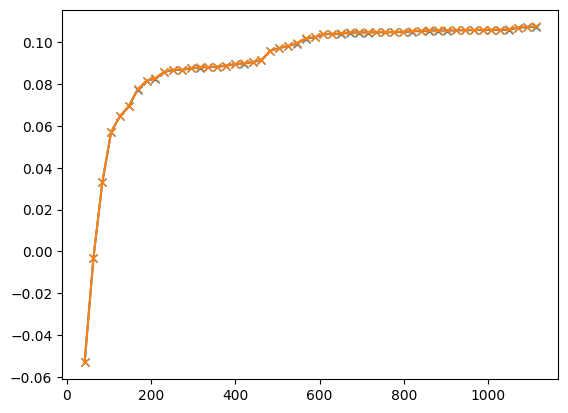

In [14]:
kappa_hats = dict()
interpolator = PchipInterpolator

startStep = 24

for endStep in endSteps_arr:
    if endStep < startStep:
        continue
    
    df = train_mean_res_df.query(f'endStep == {endStep} and startStep == {startStep}')
    
    cs = interpolator(df.loc[:, 'kappa'], df.loc[:, 'mean']-S0+K)
    kappa_hat = cs.roots()
    kappa_hat = kappa_hat[np.logical_and(kappa_hat>= min(kappa_arr), kappa_hat<= max(kappa_arr))]
    kappa_hats[endStep]  = kappa_hat[0]
    
plt.plot(pd.Series(kappa_hats), marker='x')

kappa_hats = dict()
interpolator = PchipInterpolator

for endStep in endSteps_arr:
    if endStep < startStep:
        continue
    df = test_mean_res_df.query(f'endStep == {endStep} and startStep == {startStep}')
    
    cs = interpolator(df.loc[:, 'kappa'], df.loc[:, 'mean']-S0+K)
    kappa_hat = cs.roots()
    kappa_hat = kappa_hat[np.logical_and(kappa_hat>= min(kappa_arr), kappa_hat<= max(kappa_arr))]
    kappa_hats[endStep]  = kappa_hat[0]
    
plt.plot(pd.Series(kappa_hats), marker='x')

In [15]:
kappa_hats

{42: -0.052991912136658194,
 63: -0.002901843553133457,
 84: 0.03316878707189877,
 105: 0.05730820135361739,
 126: 0.06469012781008869,
 147: 0.06945614610182002,
 168: 0.07743081055186068,
 189: 0.08167772947755864,
 210: 0.08282959779963847,
 231: 0.08590745708608935,
 252: 0.08693545436648135,
 273: 0.08688911216810354,
 294: 0.08769172068351971,
 315: 0.08799892910026536,
 336: 0.0882212103774741,
 357: 0.0884067356634187,
 378: 0.08884504277629268,
 399: 0.0896407950577054,
 420: 0.08995174443205153,
 441: 0.09060266926114191,
 462: 0.0915599225719059,
 483: 0.09603112970375897,
 504: 0.09732881675724424,
 525: 0.09831192903290764,
 546: 0.0995299295769635,
 567: 0.10194191966095591,
 588: 0.10248069560577118,
 609: 0.10400298156745284,
 630: 0.10406743282459394,
 651: 0.10420429105241794,
 672: 0.10478296171233287,
 693: 0.10479799786081477,
 714: 0.10481405401570162,
 735: 0.10492565103566341,
 756: 0.10492290401114875,
 777: 0.10492835368535514,
 798: 0.10509101377823633,
 819:

In [16]:
np.unique(train_mean_res_df.startStep)

array([   0,    1,    2, ..., 1093, 1094, 1095])

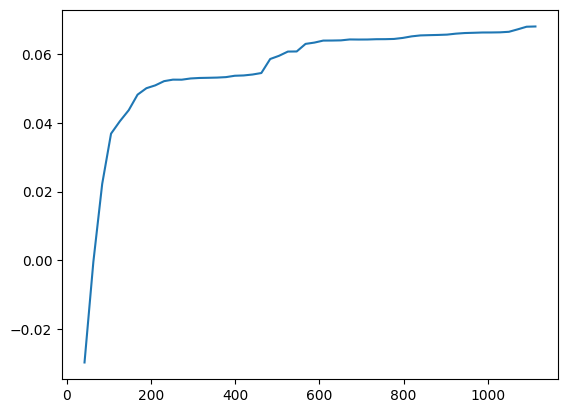

In [72]:
plt.plot(pd.Series(kappa_hats))